In [32]:
import json
import pickle
import numpy as np
from pathlib import Path
from modules.dataset import *
from torch import save, device, cuda
from torch import optim, nn
from modules.network import *
from modules.embeddings import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [33]:
device = device("cuda") if cuda.is_available() else device("cpu")
print('Selected device:', device)

Selected device: cpu


In [3]:
# Colab packages
from google.colab import files, drive

# Connect drive to colab
drive.mount('/content/drive')

# Create directories (Colab)
!mkdir ./dataset
!mkdir ./drive/My\ Drive/Colab\ Notebooks/results
!mkdir ./drive/My\ Drive/Colab\ Notebooks/results/losses

ModuleNotFoundError: No module named 'google'

# Dataset

## Loading and preprocessing

In [34]:
#%%Loading the dataset 
dataset = Mobydick('./data/mobydick.txt', min_len = 5)

with open('./data/clean_text', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    
len(dataset)

534

In [35]:
# Given a min_len>2, it is not necessary to delete the chapters titles
print(dataset[0])

['some', 'years', 'ago', 'never', 'mind', 'how', 'long', 'precisely', 'having', 'little', 'or', 'no', 'money', 'in', 'my', 'purse', ',', 'and', 'nothing', 'particular', 'to', 'interest', 'me', 'on', 'shore', ',', 'i', 'thought', 'i', 'would', 'sail', 'about', 'a', 'little', 'and', 'see', 'the', 'watery', 'part', 'of', 'the', 'world', '.']


27.44943820224719
127
5


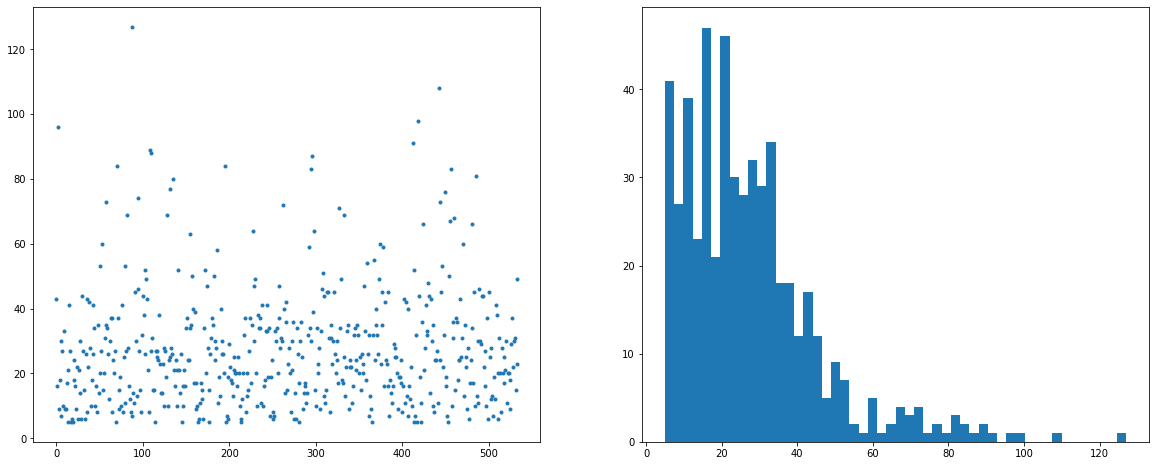

In [36]:
# Dataset visualization
lengths = [ len(sentence)  for sentence in dataset ]
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs.ravel()
_ = axs[0].plot(lengths, '.')
_ = axs[1].hist(lengths, bins=50)

print(np.mean(lengths))
print(np.max(lengths))
print(np.min(lengths))

In [37]:
# Word visualization
print(len(dataset.words))

14658


## Word embeddings

In [38]:
# define the embedding dimension
embedding_dim = 50

In [39]:
%%time 

# Load embeddings from glove
glove = Embeddings.from_file(
    path='data/glove.6B.50d.txt',
    words=dataset.words
)

CPU times: user 1min 29s, sys: 120 ms, total: 1min 29s
Wall time: 1min 29s


In [40]:
# Analyse glove embeddings
print('Mean:', np.mean(list(glove.values())), ', STD: ', np.std(list(glove.values())) )

Mean: 0.021333818937442423 , STD:  0.6608528135100873


In [41]:
# Define embeddings for unknown words by sampling from normal distirbution, using found parameters
mean = np.mean(list(glove.values()))
std = np.std(list(glove.values())) 

# Initialize randomly sampled embeddings
embeddings = Embeddings.gaussian_sampling(mean, std, dim=embedding_dim, words=dataset.words)
# Loop through each embedded word
for word, vector in embeddings.items():
    # Subsititute current entry with glove one, if available
    embeddings[word] = glove.get(word, vector)

# Get list of words
words = [*embeddings.keys()]
# Get vectors as float tensor
vectors = torch.tensor([*embeddings.values()], dtype=torch.float)

In [42]:
# Analyse generated embeddings
print('Mean:', np.mean(list(embeddings.values())), ', STD: ', np.std(list(embeddings.values())) )

Mean: 0.020534894752906683 , STD:  0.6607751838335364


In [44]:
a = vectors.shape[0] # obtained with all words in vocab and in glove + words in vocab not in glove
b = len(set(glove.keys()) & set(dataset.words)) + len(set(dataset.words) - set(glove.keys())) 
# sanity check
a == b

True

In [45]:
with open('./data/embeddings', 'wb') as f:
    pickle.dump(vectors, f, pickle.HIGHEST_PROTOCOL)

In [46]:
# reload embeddings
with open('./data/embeddings', 'rb') as f:
    vectors = pickle.load(f)

In [47]:
# Define transformation for dataset
dataset.transform = transforms.Compose([
    WordToVector(words),
    RandomCrop(10),
    ToTensor()
])

# LSTM

In [28]:
##Parameters

# network
hidden_units = 2**6 # symmetric layers
layers_num = 2
dropout_prob = 0.4

# training
batch_size = 1000
num_epochs = 5

# save
out_dir = f'LSTM_{hidden_units}_{layers_num}_{dropout_prob}'

In [29]:
# Split initial dataset in train dataset and test dataset
train_dataset, test_dataset = split_train_test(dataset, 0.9)
# Make train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Make test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [29]:
#TODO: hyperparameter optimization, this part must be included in the GridSearch iteration

#%% Initialize network
net = Network(vocab_size = vectors.shape[0],
              embedding_dim = embedding_dim,
              hidden_units = hidden_units,
              layers_num = layers_num,
              hidden_type = 'LSTM',
              trained_embeddings = vectors,
              dropout_prob = dropout_prob
             )

# Define optimizer
optimizer = optim.Adam(net.parameters(), weight_decay=5e-4)
# Define loss function
loss_fn = nn.CrossEntropyLoss()

net.to(device)

Network(
  (rnn): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.4)
  (out): Linear(in_features=64, out_features=50, bias=True)
  (embed): Embedding(3058, 50)
)

In [36]:
%%time

#%% Train network
train_loss_epochs = []
val_loss_epochs = []
for epoch in range(num_epochs):
    print('##################################')
    print('## EPOCH %d' % (epoch + 1))
    print('##################################')
    train_loss_log = []
    val_loss_log = []
    # Iterate batches
    for batch_sample in train_dataloader:
        # Extract batch
        batch = batch_sample.long().to(device)
        print(batch.shape)
        # Update network
        batch_loss = net.train_batch(batch, loss_fn, optimizer)
        train_loss_log = [].append(batch_loss)
        print('\t Training loss (single batch):', batch_loss)
        #val_loss = net.test_batch(batch, loss_fn)
        #print('\t Validation loss (single batch):', val_loss)
        #val_loss_log = [].append(val_loss)
        
    
    print('\t Training loss (epoch - mean): ', np.mean(loss_epoch) )
    train_loss_epochs.append(np.mean(train_loss_log = []))
    #val_loss_epochs.append(np.mean(val_loss_log = []))
    
#losses = { 'train': train_loss_epochs, 'val':  val_loss_epochs }

# Save losses dictionary
#colab_path = "./drive/My Drive/Colab Notebooks/results/losses"
#with open(colab_path + "/" + out_dir, 'wb') as f:
#    pickle.dump(losses, f, pickle.HIGHEST_PROTOCOL)

##################################
## EPOCH 1
##################################
torch.Size([481, 5])


ValueError: Expected target size (481, 50), got torch.Size([481])

In [ ]:
# Create output dir
out_dir.mkdir(parents=True, exist_ok=True)
# Save network parameters
torch.save(net.state_dict(), out_dir / 'net_params.pth')
# Save training parameters
with open(out_dir / 'training_args.json', 'w') as f:
    json.dump(vars(args), f, indent=4)
# Save encoder dictionary
with open(out_dir / 'char_to_number.json', 'w') as f:
    json.dump(dataset.char_to_number, f, indent=4)
# Save decoder dictionary
with open(out_dir / 'number_to_char.json', 'w') as f:
    json.dump(dataset.number_to_char, f, indent=4)